# MOWNiT

 Użycie wielomianów ortogonalnych do analizy EKG 

Instalacja wymaganych pakietów

In [1]:
using Pkg

In [2]:
# Pkg.add("Polynomials")
#Pkg.add("SpecialPolynomials")
# Pkg.add("Plots")
# Pkg.add("CSV")
# Pkg.add("DataFrames")

In [3]:
using Polynomials
using SpecialPolynomials
using Plots
using LinearAlgebra
using CSV
using DataFrames

## Teoria

**Wielomiany ortogonalne** to rodzina wielomianów, w których iloczyn skalarny dwóch róznych wielomianów jest równa 0.

Jeżeli dodatkowo iloczyn skalarny wielomianu "przez siebie" jest równy 1, to nazywamy je **wielomianami ortonormalnymi**

Iloczyn skalarny wielomianów można zdefiniować jako:

$<P_m,P_n>=\int_a^b P_n(x)P_m(x)W(x)dx = 0$

Funkcja *W* jest nazywana *funkcją wagową*.

### Przykładowe rodziny wielomianów ortogonalnych

| Nazwa                | Przedział       | Funkcja wagowa           | Zastosowanie                                           | Parzystość                                                     |
|----------------------|-----------------|--------------------------|--------------------------------------------------------|----------------------------------------------------------------|
| Czebyszewa (1 rzędu) | [-1,1]          | $\frac{1}{\sqrt{1-x^2}}$ | Zera wielomianu jako węzły interpolacji wielomianowej  | Dla parzystego k - parzyste, dla nieparzystego k - nieparzyste |
| Legendre             | [-1,1]          | 1                        | Zera wielomianu jako węzły kwadratur Gaussa-Legendre'a | jw                                                             |
| Hermite              | [$-\infty$,$\infty$] | $\exp(-x^2)$             | Zera wielomianu jako węzły kwadratur Gaussa-Hermite'a  | jw                                                             |
| Laguerre             | [0,$\infty$]      | $\exp(-x)$               | Zera wielomianu jako węzły kwadratur Gaussa-Laguerra'a | brak                                                           |


### Wielomiany Hermite'a

Zdefiniowane są rekurencyjnie jako:

$H_0(x) = 1$

$H_1(x) = 2x$

$H_{n+1}(x) = 2xH_n(x)-2nH_{n-1}$

Wykres przykładowego wielomianu (tutaj 3 stopnia)

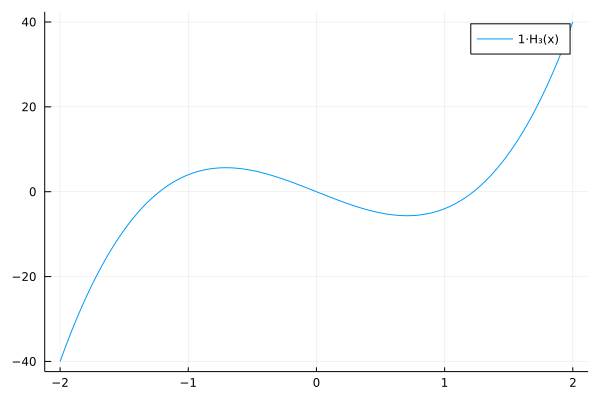

In [4]:
h3 = Hermite([0, 0, 0, 1])
plot(h3, -2, 2)

Żeby nie podawać wektora ze współczynnikami kolejnych stopni, można zrobić inaczej

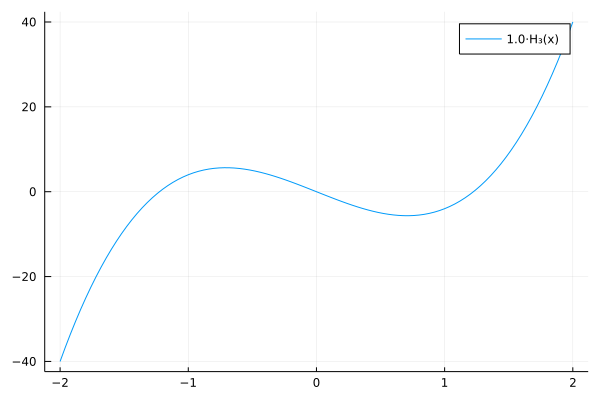

In [5]:
h4 = basis(Hermite, 3)
plot(h4, -2, 2)

### Przykład aproksymacji

Spróbujemy dokonać aproksymacji zaszumionej funkcji `cos` wykorzystując rodzinę wielomianów ortogonalnych Hermite'a.

In [6]:
# Definicja węzłów
xx = -5:.1:5
yy = cos.(xx/3 .+.2).^2 .+ rand(length(xx))/5;

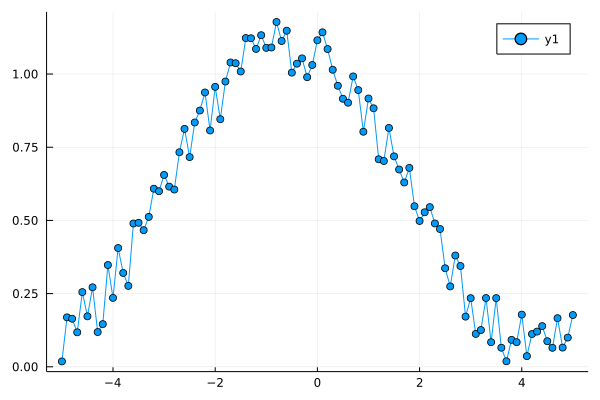

In [7]:
plot(xx, yy, markershape=:circle)

Obliczony wektor wartości normalizujemy do 1, żeby łatwiej policzyć współczynniki aproksymacji (niżej objaśnienie dlaczego łatwiej). 

In [8]:
#przykład prostego wektora, który znormalizujemy
vec=[2,2,2,2]

4-element Array{Int64,1}:
 2
 2
 2
 2

In [9]:
# iloczyn skalarny = długość^2
dot(vec,vec)

16

In [10]:
# normalizacja - długość wektora =1
normalize(vec)

4-element Array{Float64,1}:
 0.5
 0.5
 0.5
 0.5

In [11]:
# sprawdzamy długość^2
dot(normalize(vec), normalize(vec))

1.0

* 0bliczamy funkcję bazową uwzględniającą czynnik wagowy.
$<P_m,P_n>=\int_{-\infty}^{\infty} H_n(x)H_m(x)\exp(-x^2)dx 
= \int_{-\infty}^{\infty}\underbrace{H_n(x)\exp(-\frac{x^2}{2})}_{\text{funkcja bazowa}_n}\underbrace{H_m(x)\exp(-\frac{x^2}{2})}_{\text{funkcja bazowa}_m}$

* Wyliczamy jej wartości dla podanych punktów x
* Otrzymany wektor wartości normalizujemy


In [12]:
# obliczamy funkcję bazową
# argument 'norm'  na potrzeby wykresów
function base_fun(k, x, norm=true)
    H_k = basis(Hermite, k).(x)
    app = H_k .* exp.(-(x.^2)/2)
    # normalize to have norm 1
    if norm
        return normalize(app)
    end
    return app
end

base_fun (generic function with 2 methods)

In [13]:
y_2_unnorm = base_fun(2, xx, false);
y_2_norm = base_fun(2, xx);

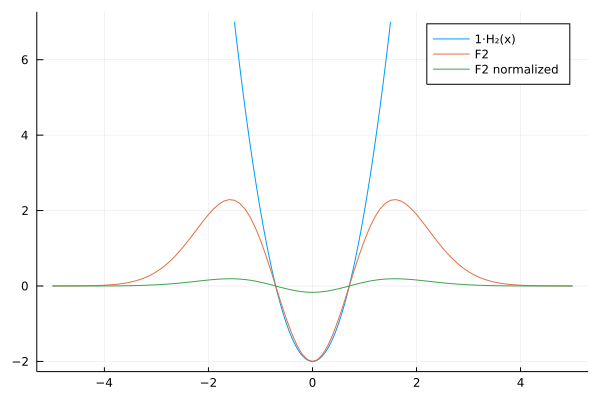

In [14]:
plot(Hermite([0, 0, 1]), -1.5, 1.5)
plot!(xx, y_2_unnorm, label="F2")
plot!(xx, y_2_norm, label="F2 normalized")

Obliczamy wektory wartosci dla punktów w xx dla kilku kolejnych funkcji bazowych

In [15]:
f0 = base_fun(0, xx, true);
f1 = base_fun(1, xx, true);
f2 = base_fun(2, xx, true);
f3 = base_fun(3, xx, true);

Sprawdźmy czy baza jest ortonormalna (uwaga: zamiast liczyć całkę, sprawdzamy po prostu iloczyn skalarny wektorów wartości)

In [16]:
dot_base = Array{Float64, 2}(undef, 4, 4); 

for (i, f_i) in enumerate([f0, f1, f2, f3]) 
    for (j, f_j) in enumerate([f0, f1, f2, f3])
        dot_base[i,j] = dot(f_i, f_j)
    end
end

In [17]:
dot_base

4×4 Array{Float64,2}:
  1.0           2.01999e-18  -3.25357e-11   2.40981e-19
  2.01999e-18   1.0          -9.96958e-18  -9.61163e-10
 -3.25357e-11  -9.96958e-18   1.0          -8.92434e-18
  2.40981e-19  -9.61163e-10  -8.92434e-18   1.0

OK, baza jest ortonormalna

Obliczamy kolejne współczynniki aproksymacji. Dzięki ortonormalnej bazie, poszczególne współczynniki są iloczynami skalarnymi wektora wartości funkcji aproksymowanej oraz  wektora bazowego (analogia: rzut  wektora wartości funkcji aproksymowanej w kierunku wektora bazowego).

Wektor bazowy jest znormalizowany $|\vec{j}|=1$, co upraszcza obliczenia.

Analogia w 2D

$\text{rzut }\vec{a} \text{ w kierunku }  \vec{j} =|\vec{a}|\cdot cos(\angle(\vec{a},\vec{j}))=|\vec{a}|\cdot|\vec{j}|\cdot cos(\angle(\vec{a},\vec{j}))=dot(\vec{a},\vec{j})$

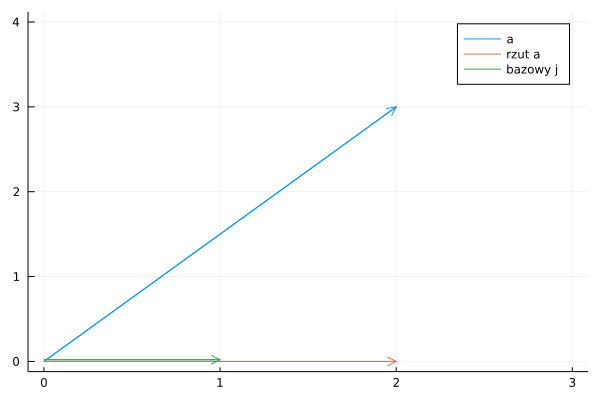

In [18]:
plot([0,2],[0,3],xrange=[0,3], yrange=[0,4],arrow=true, label="a")
plot!([0,2],[0,0],xrange=[0,3], yrange=[0,4],arrow=true, label="rzut a")
plot!([0,1],[0.02,0.02],xrange=[0,3], yrange=[0,4],arrow=true, label="bazowy j")

In [19]:
c0 = dot(yy, f0)
c1 = dot(yy, f1)
c2 = dot(yy, f2)
c3 = dot(yy, f3)
c0, c1, c2, c3

(5.81855961859754, -0.892637652150945, 2.8711269545021354, -0.7844400554510714)

Liczymy wartości aproksymowane kolejnymi stopniami

In [20]:
y_app_0 = c0*f0;
y_app_1 = c1*f1;
y_app_2 = c2*f2;
y_app_3 = c3*f3;

In [21]:
y_app_01 = y_app_0 + y_app_1;
y_app_012 = y_app_01 + y_app_2;
y_app_0123 = y_app_012 + y_app_3;

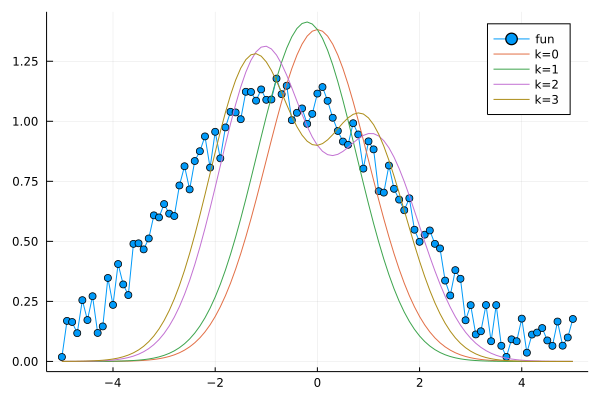

In [22]:
plot(xx, yy, markershape=:circle, label="fun")
plot!(xx, y_app_0, label="k=0")
plot!(xx, y_app_01, label="k=1")
plot!(xx, y_app_012, label="k=2")
plot!(xx, y_app_0123, label="k=3")

Liczymy błędy aproksymacji kolejnymi stopniami

In [23]:
using Statistics

In [24]:
mse(y1, y2) = mean((y1-y2).^2)

mse (generic function with 1 method)

In [25]:
mse(yy, y_app_0)

0.1406882773368646

In [26]:
mse(yy, y_app_01)

0.13279914884144328

In [27]:
mse(yy, y_app_012)

0.05118162418841584

In [28]:
mse(yy, y_app_0123)

0.04508908753552343

### EKG

Dane pochodzą z bazy https://www.physionet.org/content/mitdb/1.0.0/ .

W sygnale można wyróżnić wiele struktur, z których najbardziej charakterystyczną jest zespół QRS.

In [29]:
ekg_data = CSV.read("ecg_data.csv", DataFrame);

In [30]:
first(ekg_data, 5)

,time,signalN,signalV
,Float64,Float64,Float64
1,-0.1,0.0183886,-0.0990972
2,-0.0972222,0.0145191,-0.0920442
3,-0.0944444,0.012849,-0.0831644
4,-0.0916667,0.0124946,-0.0722728
5,-0.0888889,0.0124117,-0.0593656


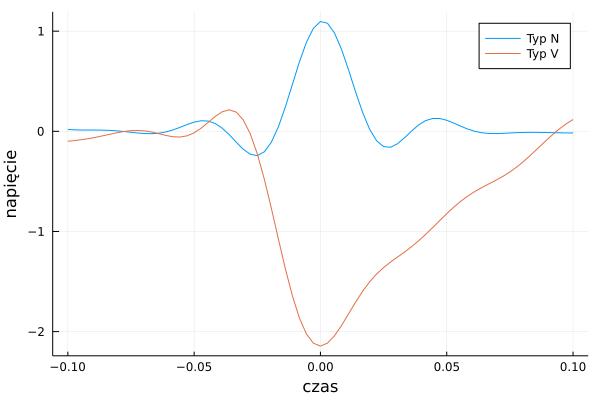

In [31]:
plot(ekg_data.time, ekg_data.signalN, label="Typ N", xlabel = "czas", ylabel="napięcie")
plot!(ekg_data.time, ekg_data.signalV, label="Typ V")

(5.725113911598116, -0.9157906158817669, 2.711325477169205, -0.8018390195854078)

Uwaga: Funkcje bazowe mają pewną "szerokość" i najlepiej aproksymują inne funkcje o podobnej szerokości. Można dodatkowo sparametryzować f. bazowe aby były węższe i lepiej pasowały do zespołów QRS. Na potrzeby laboratorium postąpimy inaczej - przeskalujemy oś X aproksymowanych sygnałów.

In [32]:
# Definicja węzłów
xx_ekg = ekg_data.time*40
yy_ekgV = ekg_data.signalV;

## Zadania

#### Zadanie 1 (1 pkt)

Narysować 6 pierwszych wielomianów Hermita (na jednym wykresie albo siatce 2x3 lub 3x2)

#### Zadanie 2  (1 pkt)

Narysować 6 pierwszych funkcji aproksymujących

#### Zadanie 3  (1 pkt)

Pokazać, że same wielomiany nie są ortogonane, ale już z funkcją wagową $exp(-x^2)$ są. Uzyć metody z wektorami wartości, założyć pewien przedział.

#### Zadanie 4  (1 pkt)

Dokonać aproksymacji zespołu QRS typu N oraz V za pomocą kilku kolejnych stopni. Przedstawić osobno wykresy dla N i V.

#### Zadanie 5  (1 pkt)

Przedstawić wykres błędu aproksymacji w zależności od stopnia wielomianu dla stopni od 0 do 10. Jakiego stopnia należy użyć gdybyśmy mieli robić coś dalej z rezultatem aproksymacji?